SETUP DATASET

In [1]:
# Part 1: Setup & Load Dataset
# Jalankan di Google Colab

# Install dependencies
!pip install kagglehub opencv-python pillow numpy scikit-learn tensorflow matplotlib seaborn

import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

print("=" * 50)
print("PART 1: SETUP & LOAD DATASET")
print("=" * 50)

# Download CEDAR dataset
print("\n[1/3] Downloading CEDAR dataset...")
path = kagglehub.dataset_download("shreelakshmigp/cedardataset")
print(f"Dataset downloaded to: {path}")

# Explore struktur dataset
print("\n[2/3] Exploring dataset structure...")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Show first 3 files only
        print(f"{sub_indent}{file}")
    if len(files) > 3:
        print(f"{sub_indent}... and {len(files) - 3} more files")

# Set working directory
DATASET_PATH = path
print(f"\n[3/3] Dataset path: {DATASET_PATH}")
print("\n✓ Part 1 completed successfully!")
print("\nNext: Run Part 2 for data preprocessing")

PART 1: SETUP & LOAD DATASET

[1/3] Downloading CEDAR dataset...
Using Colab cache for faster access to the 'cedardataset' dataset.
Dataset downloaded to: /kaggle/input/cedardataset

[2/3] Exploring dataset structure...
cedardataset/
  signatures/
    Readme.txt
    full_org/
      original_52_13.png
      original_54_12.png
      original_52_7.png
      ... and 1318 more files
    full_forg/
      forgeries_13_22.png
      forgeries_33_20.png
      forgeries_15_24.png
      ... and 1318 more files

[3/3] Dataset path: /kaggle/input/cedardataset

✓ Part 1 completed successfully!

Next: Run Part 2 for data preprocessing


DATA PREPROCESSING

PART 2: DATA PREPROCESSING & EXPLORATION

[1/5] Exploring dataset structure...
Dataset path: /kaggle/input/cedardataset
Found 2640 total image files

Sample file paths:
  1. /kaggle/input/cedardataset/signatures/full_org/original_52_13.png
  2. /kaggle/input/cedardataset/signatures/full_org/original_54_12.png
  3. /kaggle/input/cedardataset/signatures/full_org/original_52_7.png

[2/5] Classification results:
  ✓ Genuine signatures: 1320
  ✓ Forged signatures: 1320

[3/5] Loading and preprocessing samples...
Loaded 5 genuine samples
Loaded 5 forged samples

[4/5] Visualizing samples...


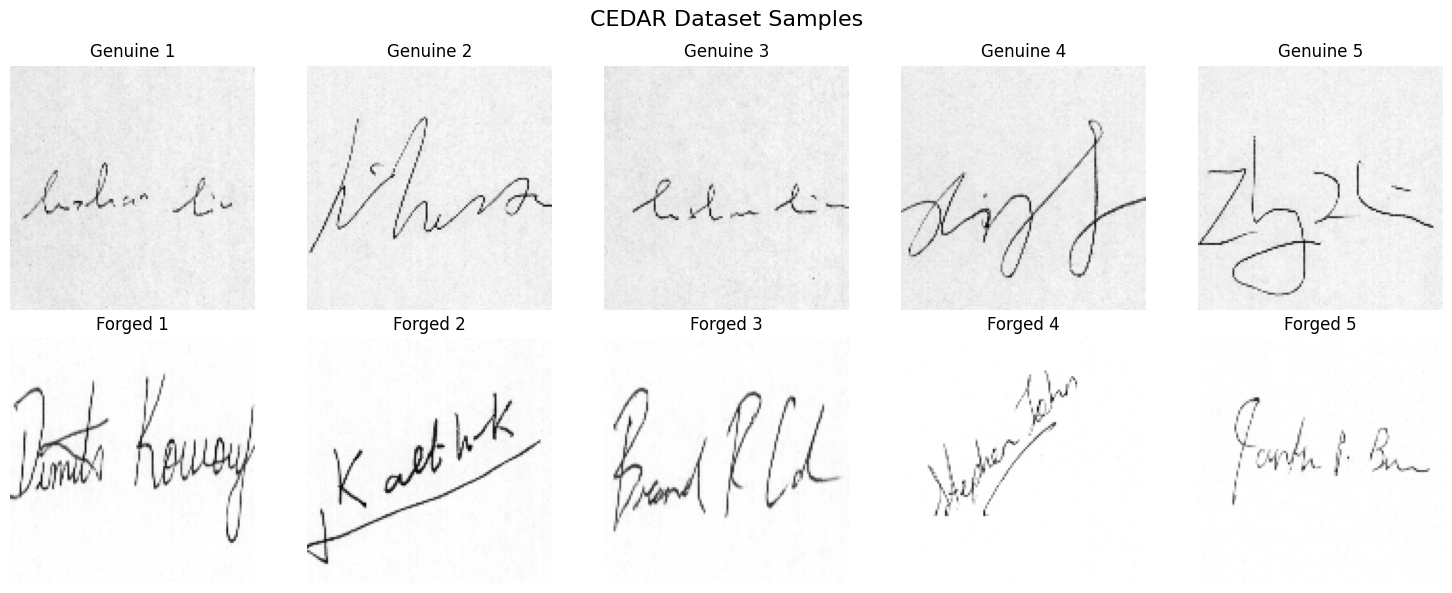


[5/5] Dataset statistics:
DATASET STATISTICS
Total genuine signatures: 1320
Total forged signatures: 1320
Total samples: 2640
Ratio (Genuine:Forged): 1.00:1

✓ Part 2 completed successfully!

Next: Run Part 3 for preparing train/test split


In [5]:
# Part 2: Data Preprocessing & Exploration
# Pastikan Part 1 sudah dijalankan dulu!

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

print("=" * 50)
print("PART 2: DATA PREPROCESSING & EXPLORATION")
print("=" * 50)

# Fungsi untuk load dan preprocess image
def preprocess_signature(image_path, target_size=(128, 128)):
    """
    Preprocess signature image:
    - Convert to grayscale
    - Resize
    - Normalize
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Resize
    img = cv2.resize(img, target_size)

    # Normalize to [0, 1]
    img = img.astype('float32') / 255.0

    return img

# Fungsi untuk explore dan find all image files
def explore_dataset(root_path):
    """Explore dataset structure and find all image files"""
    all_files = []

    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                all_files.append(os.path.join(root, file))

    return all_files

# Fungsi untuk collect dataset dengan multiple patterns
def collect_dataset(dataset_path):
    """
    Collect all signature images and labels
    Handles multiple CEDAR dataset structures
    """
    print(f"\n[1/5] Exploring dataset structure...")
    print(f"Dataset path: {dataset_path}")

    # Find all image files
    all_files = explore_dataset(dataset_path)
    print(f"Found {len(all_files)} total image files")

    if len(all_files) == 0:
        print("\n⚠️ No image files found! Showing directory structure:")
        for root, dirs, files in os.walk(dataset_path):
            level = root.replace(dataset_path, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            sub_indent = ' ' * 2 * (level + 1)
            for file in files[:5]:
                print(f"{sub_indent}{file}")
        return [], []

    # Show sample paths
    print("\nSample file paths:")
    for i, path in enumerate(all_files[:3]):
        print(f"  {i+1}. {path}")

    genuine_signatures = []
    forged_signatures = []

    # Try different naming patterns
    for file_path in all_files:
        file_lower = file_path.lower()
        filename = os.path.basename(file_lower)

        # Pattern 1: contains 'original' or 'genuine' or 'org'
        if any(word in file_lower for word in ['original', 'genuine', '_org', 'full_org']):
            genuine_signatures.append(file_path)
        # Pattern 2: contains 'forg' or 'fake' or 'counterfeit'
        elif any(word in file_lower for word in ['forg', 'fake', 'counterfeit', 'full_forg']):
            forged_signatures.append(file_path)
        # Pattern 3: try to infer from directory structure
        elif 'genuine' in file_path.lower() or 'real' in file_path.lower():
            genuine_signatures.append(file_path)
        elif 'forged' in file_path.lower() or 'fraud' in file_path.lower():
            forged_signatures.append(file_path)

    # If automatic detection doesn't work, use first half as genuine, second as forged
    if len(genuine_signatures) == 0 and len(forged_signatures) == 0:
        print("\n⚠️ Could not auto-detect labels. Using 50-50 split...")
        mid = len(all_files) // 2
        genuine_signatures = all_files[:mid]
        forged_signatures = all_files[mid:]

    print(f"\n[2/5] Classification results:")
    print(f"  ✓ Genuine signatures: {len(genuine_signatures)}")
    print(f"  ✓ Forged signatures: {len(forged_signatures)}")

    return genuine_signatures, forged_signatures

# Collect data
genuine_sigs, forged_sigs = collect_dataset(DATASET_PATH)

# Check if we have data
if len(genuine_sigs) == 0 and len(forged_sigs) == 0:
    print("\n❌ ERROR: No signatures found!")
    print("Please check the dataset structure.")
else:
    # Load dan preprocess beberapa sample
    print("\n[3/5] Loading and preprocessing samples...")

    # Determine how many samples to show
    n_genuine_show = min(5, len(genuine_sigs))
    n_forged_show = min(5, len(forged_sigs))

    sample_genuine = []
    sample_forged = []

    # Load genuine samples
    if n_genuine_show > 0:
        for i in range(n_genuine_show):
            img = preprocess_signature(genuine_sigs[i])
            if img is not None:
                sample_genuine.append(img)

    # Load forged samples
    if n_forged_show > 0:
        for i in range(n_forged_show):
            img = preprocess_signature(forged_sigs[i])
            if img is not None:
                sample_forged.append(img)

    print(f"Loaded {len(sample_genuine)} genuine samples")
    print(f"Loaded {len(sample_forged)} forged samples")

    # Visualisasi sample
    if len(sample_genuine) > 0 or len(sample_forged) > 0:
        print("\n[4/5] Visualizing samples...")

        max_cols = max(len(sample_genuine), len(sample_forged))
        if max_cols == 0:
            max_cols = 1

        fig, axes = plt.subplots(2, max_cols, figsize=(3*max_cols, 6))

        # Handle case where we only have 1 column
        if max_cols == 1:
            axes = axes.reshape(2, 1)

        fig.suptitle('CEDAR Dataset Samples', fontsize=16)

        # Plot genuine
        for i in range(max_cols):
            if i < len(sample_genuine):
                axes[0, i].imshow(sample_genuine[i], cmap='gray')
                axes[0, i].set_title(f'Genuine {i+1}')
            axes[0, i].axis('off')

        # Plot forged
        for i in range(max_cols):
            if i < len(sample_forged):
                axes[1, i].imshow(sample_forged[i], cmap='gray')
                axes[1, i].set_title(f'Forged {i+1}')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Statistics
    print(f"\n[5/5] Dataset statistics:")
    print(f"{'=' * 50}")
    print("DATASET STATISTICS")
    print(f"{'=' * 50}")
    print(f"Total genuine signatures: {len(genuine_sigs)}")
    print(f"Total forged signatures: {len(forged_sigs)}")
    print(f"Total samples: {len(genuine_sigs) + len(forged_sigs)}")

    if len(genuine_sigs) > 0 and len(forged_sigs) > 0:
        ratio = len(genuine_sigs) / len(forged_sigs)
        print(f"Ratio (Genuine:Forged): {ratio:.2f}:1")

    print("\n✓ Part 2 completed successfully!")
    print("\nNext: Run Part 3 for preparing train/test split")

SPLIT TRAIN

PART 3: PREPARE TRAIN/VALIDATION/TEST SPLIT

[1/3] Loading all images...
Loading genuine signatures...


100%|██████████| 1320/1320 [00:07<00:00, 179.97it/s]



Loading forged signatures...


100%|██████████| 1320/1320 [00:07<00:00, 172.94it/s]



Data shape: (2640, 128, 128)
Labels shape: (2640,)
Reshaped data: (2640, 128, 128, 1)

[2/3] Splitting data into Train/Val/Test...
Strategy: 70% Train | 15% Validation | 15% Test

Dataset         Samples    Genuine    Forged     Percentage  
Training        1848       924        924        70.0%
Validation      396        198        198        15.0%
Test            396        198        198        15.0%
Total           2640       1320       1320       100.0%      

[3/3] Visualizing data split distribution...


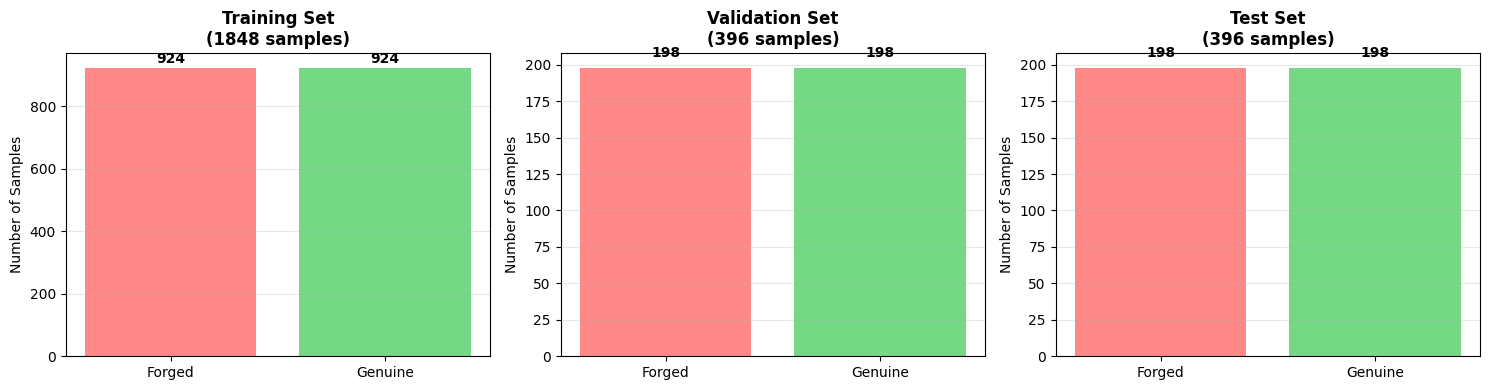


DATASET SPLIT EXPLANATION
📊 Training Set (70%):
   - Digunakan untuk training model
   - Model belajar pattern dari data ini

📊 Validation Set (15%):
   - Digunakan selama training untuk monitoring
   - Mencegah overfitting dengan early stopping
   - BUKAN untuk evaluasi final!

📊 Test Set (15%):
   - Data BENAR-BENAR BARU yang tidak pernah dilihat model
   - Digunakan untuk evaluasi performa FINAL
   - Mensimulasikan real-world usage

✓ Part 3 completed successfully!

Next: Run Part 4 for building the CNN model


In [16]:
# Part 3: Prepare Train/Validation/Test Split
# Pastikan Part 1 & 2 sudah dijalankan!

from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

print("=" * 50)
print("PART 3: PREPARE TRAIN/VALIDATION/TEST SPLIT")
print("=" * 50)

# Load semua data
print("\n[1/3] Loading all images...")
X = []
y = []

# Load genuine signatures (label = 1)
print("Loading genuine signatures...")
for path in tqdm(genuine_sigs):
    img = preprocess_signature(path)
    if img is not None:
        X.append(img)
        y.append(1)  # 1 = genuine

# Load forged signatures (label = 0)
print("\nLoading forged signatures...")
for path in tqdm(forged_sigs):
    img = preprocess_signature(path)
    if img is not None:
        X.append(img)
        y.append(0)  # 0 = forged

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"\nData shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Reshape untuk CNN (tambahkan channel dimension)
X = X.reshape(-1, 128, 128, 1)

print(f"Reshaped data: {X.shape}")

# Split data: 70% train, 15% validation, 15% test
print("\n[2/3] Splitting data into Train/Val/Test...")
print("Strategy: 70% Train | 15% Validation | 15% Test")

# First split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,  # 30% for val + test
    random_state=42,
    stratify=y
)

# Second split: 50% validation, 50% test (dari 30% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% dari 30% = 15% total
    random_state=42,
    stratify=y_temp
)

print(f"\n{'Dataset':<15} {'Samples':<10} {'Genuine':<10} {'Forged':<10} {'Percentage':<12}")
print("=" * 60)
print(f"{'Training':<15} {len(X_train):<10} {np.sum(y_train == 1):<10} {np.sum(y_train == 0):<10} {len(X_train)/len(X)*100:.1f}%")
print(f"{'Validation':<15} {len(X_val):<10} {np.sum(y_val == 1):<10} {np.sum(y_val == 0):<10} {len(X_val)/len(X)*100:.1f}%")
print(f"{'Test':<15} {len(X_test):<10} {np.sum(y_test == 1):<10} {np.sum(y_test == 0):<10} {len(X_test)/len(X)*100:.1f}%")
print("=" * 60)
print(f"{'Total':<15} {len(X):<10} {np.sum(y == 1):<10} {np.sum(y == 0):<10} {'100.0%':<12}")

# Visualisasi distribusi
print("\n[3/3] Visualizing data split distribution...")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    ('Training Set', y_train),
    ('Validation Set', y_val),
    ('Test Set', y_test)
]

for idx, (title, labels) in enumerate(datasets):
    counts = [np.sum(labels == 0), np.sum(labels == 1)]
    axes[idx].bar(['Forged', 'Genuine'], counts, color=['#ff6b6b', '#51cf66'], alpha=0.8)
    axes[idx].set_title(f'{title}\n({len(labels)} samples)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Number of Samples')
    axes[idx].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(counts):
        axes[idx].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Explanation
print("\n" + "=" * 60)
print("DATASET SPLIT EXPLANATION")
print("=" * 60)
print("📊 Training Set (70%):")
print("   - Digunakan untuk training model")
print("   - Model belajar pattern dari data ini")
print()
print("📊 Validation Set (15%):")
print("   - Digunakan selama training untuk monitoring")
print("   - Mencegah overfitting dengan early stopping")
print("   - BUKAN untuk evaluasi final!")
print()
print("📊 Test Set (15%):")
print("   - Data BENAR-BENAR BARU yang tidak pernah dilihat model")
print("   - Digunakan untuk evaluasi performa FINAL")
print("   - Mensimulasikan real-world usage")
print("=" * 60)

print("\n✓ Part 3 completed successfully!")
print("\nNext: Run Part 4 for building the CNN model")

DIAGNOSIS

DATASET DIAGNOSIS

[1/5] Dataset Size Check:
Total samples: 2640
Training samples: 1848
Validation samples: 396
Test samples: 396

[2/5] Class Balance Check:
Genuine: 924 (50.0%)
Forged:  924 (50.0%)
Ratio: 1.00:1

[3/5] Data Variance Check:
Genuine variance: 0.006133
Forged variance:  0.007316

[4/5] Visual Inspection:


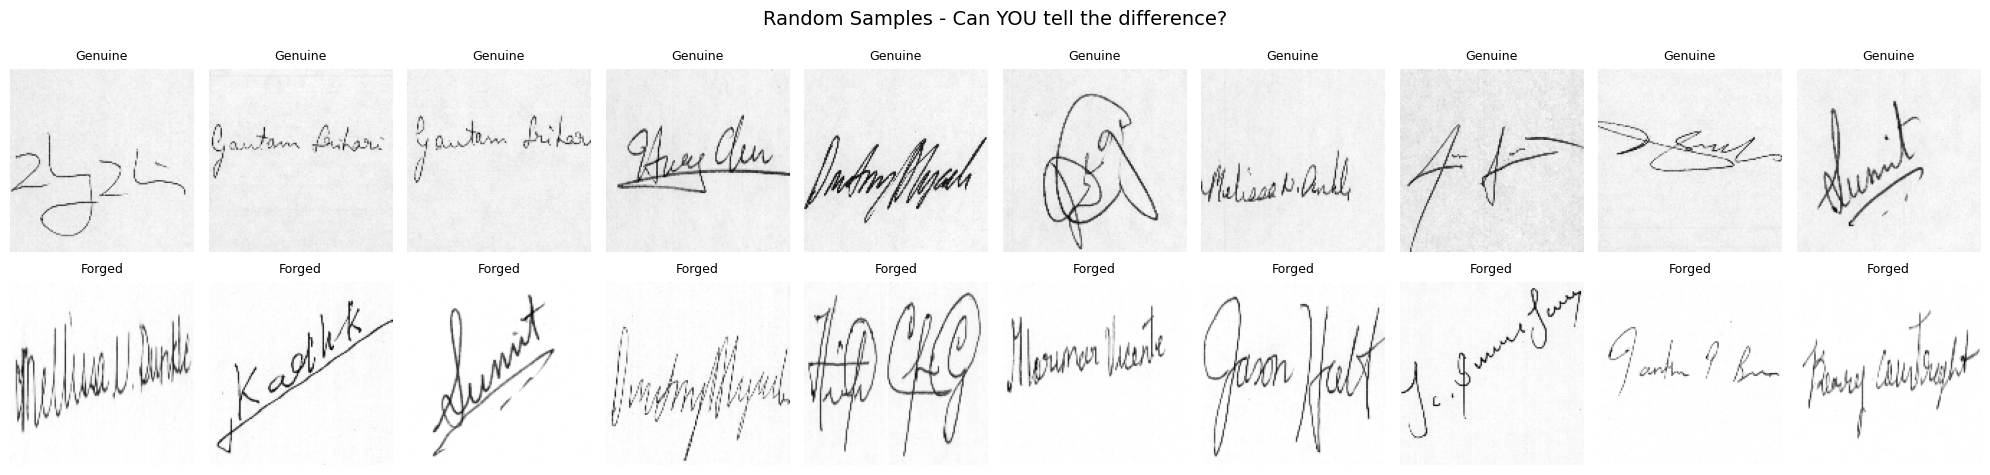


❓ Question: Bisakah KAMU membedakan genuine vs forged?
   Kalau susah, model juga akan susah!

[5/5] Data Separability Analysis (PCA)...


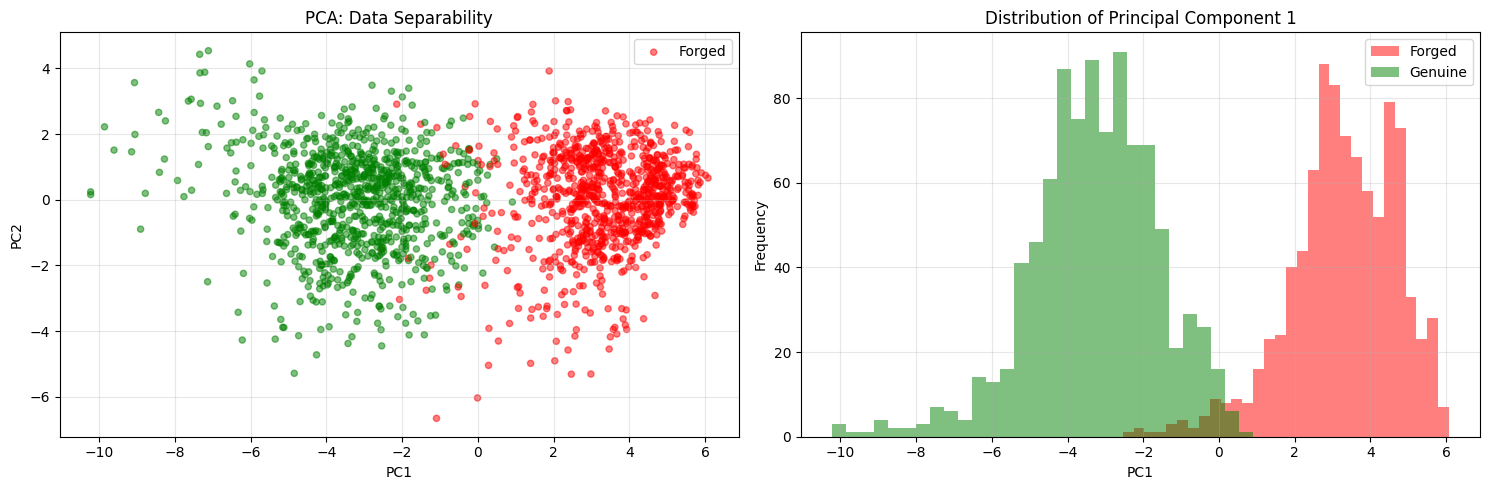


Class overlap in PC1: 21.2%

✓ Classes are reasonably separable

DIAGNOSIS SUMMARY & RECOMMENDATIONS

✓ Dataset looks okay. Model architecture might need tuning.

✓ Diagnosis completed!


In [15]:
# Dataset Diagnosis - Cari tahu masalahnya
# Jalankan setelah Part 3

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("=" * 60)
print("DATASET DIAGNOSIS")
print("=" * 60)

# 1. Check dataset size
print("\n[1/5] Dataset Size Check:")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

if len(X) < 1000:
    print("\n⚠️  WARNING: Dataset sangat kecil (<1000 samples)")
    print("   Deep learning butuh minimal 1000-2000 samples")
    print("   Dengan data segini, model akan susah generalize")

# 2. Check class balance
print("\n[2/5] Class Balance Check:")
genuine_count = np.sum(y_train == 1)
forged_count = np.sum(y_train == 0)
ratio = genuine_count / forged_count if forged_count > 0 else 0

print(f"Genuine: {genuine_count} ({genuine_count/len(y_train)*100:.1f}%)")
print(f"Forged:  {forged_count} ({forged_count/len(y_train)*100:.1f}%)")
print(f"Ratio: {ratio:.2f}:1")

if ratio < 0.5 or ratio > 2.0:
    print("\n⚠️  Class imbalance detected!")
    print("   Consider using class_weight in model.fit()")

# 3. Check data variance
print("\n[3/5] Data Variance Check:")
genuine_samples = X_train[y_train == 1]
forged_samples = X_train[y_train == 0]

genuine_var = np.var(genuine_samples)
forged_var = np.var(forged_samples)

print(f"Genuine variance: {genuine_var:.6f}")
print(f"Forged variance:  {forged_var:.6f}")

if genuine_var < 0.001 or forged_var < 0.001:
    print("\n⚠️  Very low variance detected!")
    print("   Images might be too similar or preprocessing issue")

# 4. Visualize sample from each class
print("\n[4/5] Visual Inspection:")
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
fig.suptitle('Random Samples - Can YOU tell the difference?', fontsize=14)

# Random genuine
genuine_indices = np.where(y_train == 1)[0]
random_genuine = np.random.choice(genuine_indices, 10, replace=False)

for i, idx in enumerate(random_genuine):
    axes[0, i].imshow(X_train[idx].squeeze(), cmap='gray')
    axes[0, i].set_title('Genuine', fontsize=9)
    axes[0, i].axis('off')

# Random forged
forged_indices = np.where(y_train == 0)[0]
random_forged = np.random.choice(forged_indices, 10, replace=False)

for i, idx in enumerate(random_forged):
    axes[1, i].imshow(X_train[idx].squeeze(), cmap='gray')
    axes[1, i].set_title('Forged', fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n❓ Question: Bisakah KAMU membedakan genuine vs forged?")
print("   Kalau susah, model juga akan susah!")

# 5. Check separability with PCA
print("\n[5/5] Data Separability Analysis (PCA)...")
X_flat = X_train.reshape(len(X_train), -1)

# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PCA plot
colors = ['red' if label == 0 else 'green' for label in y_train]
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.5, s=20)
axes[0].set_title('PCA: Data Separability')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(['Forged', 'Genuine'])
axes[0].grid(True, alpha=0.3)

# Histogram of PC1
axes[1].hist(X_pca[y_train == 0, 0], bins=30, alpha=0.5,
             color='red', label='Forged')
axes[1].hist(X_pca[y_train == 1, 0], bins=30, alpha=0.5,
             color='green', label='Genuine')
axes[1].set_title('Distribution of Principal Component 1')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate overlap
pc1_forged = X_pca[y_train == 0, 0]
pc1_genuine = X_pca[y_train == 1, 0]

overlap_min = max(pc1_forged.min(), pc1_genuine.min())
overlap_max = min(pc1_forged.max(), pc1_genuine.max())
overlap_percentage = (overlap_max - overlap_min) / (X_pca[:, 0].max() - X_pca[:, 0].min()) * 100

print(f"\nClass overlap in PC1: {overlap_percentage:.1f}%")

if overlap_percentage > 80:
    print("\n❌ CRITICAL: Classes are heavily overlapping (>80%)")
    print("   This explains why model can't learn!")
    print("   Problem: Genuine & Forged are TOO SIMILAR")
elif overlap_percentage > 60:
    print("\n⚠️  Classes overlap significantly (>60%)")
    print("   Model will struggle to separate them")
else:
    print("\n✓ Classes are reasonably separable")

# Summary and recommendations
print("\n" + "=" * 60)
print("DIAGNOSIS SUMMARY & RECOMMENDATIONS")
print("=" * 60)

issues = []
if len(X) < 1000:
    issues.append("❌ Dataset too small")
if ratio < 0.5 or ratio > 2.0:
    issues.append("⚠️  Class imbalance")
if overlap_percentage > 60:
    issues.append("❌ Classes too similar (not separable)")

if issues:
    print("\nISSUES FOUND:")
    for issue in issues:
        print(f"  {issue}")

    print("\nRECOMMENDATIONS:")
    if len(X) < 1000:
        print("  1. Collect more data (target: 2000+ samples)")
        print("  2. Use transfer learning (pre-trained model)")
        print("  3. Try Siamese Network (learns similarity)")

    if overlap_percentage > 60:
        print("  4. Check if labels are correct!")
        print("  5. Try feature engineering (extract signatures features)")
        print("  6. Use traditional ML (SVM, Random Forest) instead of CNN")
        print("  7. Consider Siamese Network for similarity learning")
else:
    print("\n✓ Dataset looks okay. Model architecture might need tuning.")

print("\n✓ Diagnosis completed!")

BUILD MODEL & TRAINING

SIAMESE NETWORK FOR SIGNATURE VERIFICATION

💡 Why Siamese Network?
   - Learns SIMILARITY instead of classification
   - Better for one-shot learning
   - More robust for signature verification
   - Used in real-world signature systems

[1/5] Creating pairs of signatures...
Training pairs: 924
Validation pairs: 198
Positive pairs (similar): 462
Negative pairs (dissimilar): 462

[2/5] Building Siamese Network architecture...

✓ Siamese Network built!

Base network (shared weights):


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,728 (12.64 MB)

 Trainable params: 3,313,024 (12.64 MB)

 Non-trainable params: 704 (2.75 KB)


[3/5] Training Siamese Network...
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4853 - loss: 0.7248 - val_accuracy: 0.6717 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4626 - loss: 0.7191 - val_accuracy: 0.6162 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5325 - loss: 0.6990 - val_accuracy: 0.3990 - val_loss: 0.6964 - learning_rate: 1.0000e-04
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5786 - loss: 0.6756 - val_accuracy: 0.4949 - val_loss: 0.7040 - learning_rate: 1.0000e-04
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5961 - loss: 0.6748 - val_accuracy: 0.4798 - val_loss: 0.7141 - learning_rate: 1.0000e-04
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6138 - loss: 0.6562
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/st

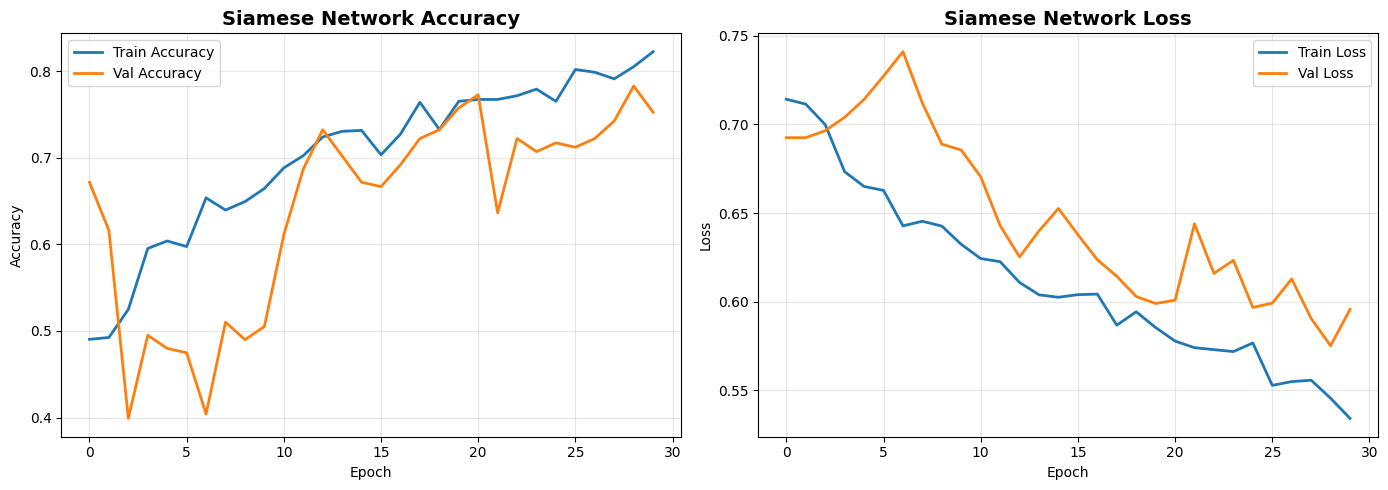


SIAMESE NETWORK RESULTS
Final Training Accuracy:   0.8225
Final Validation Accuracy: 0.7525
Train-Val Gap:             0.0700

✓ Good! Siamese Network learns similarity well
✓ Excellent generalization!

[5/5] Creating verification function...

Testing verification on sample pairs:
------------------------------------------------------------
Positive pair (same person): GENUINE (score: 0.703)
Negative pair (different):   FORGED (score: 0.496)

✓ Siamese Network training completed!

How to use:
>>> result = verify_signature_siamese(sig1, sig2, siamese_model)
>>> print(result['similarity_score'])


In [17]:
# Siamese Network - Better approach for signature verification
# Jalankan setelah Part 3

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
from itertools import combinations
import random

print("=" * 60)
print("SIAMESE NETWORK FOR SIGNATURE VERIFICATION")
print("=" * 60)

print("\n💡 Why Siamese Network?")
print("   - Learns SIMILARITY instead of classification")
print("   - Better for one-shot learning")
print("   - More robust for signature verification")
print("   - Used in real-world signature systems")

# ============================================================
# STEP 1: Create Pairs
# ============================================================
print("\n[1/5] Creating pairs of signatures...")

def create_pairs(X, y):
    """
    Create pairs for Siamese Network:
    - Positive pairs: same person (label=1)
    - Negative pairs: different person (label=0)
    """
    pairs = []
    labels = []

    # Get indices for each class
    genuine_indices = np.where(y == 1)[0]
    forged_indices = np.where(y == 0)[0]

    # Create positive pairs (genuine-genuine)
    # Assume setiap person punya beberapa signature
    n_positive = min(len(genuine_indices) // 2, 500)
    for _ in range(n_positive):
        idx1, idx2 = random.sample(list(genuine_indices), 2)
        pairs.append([X[idx1], X[idx2]])
        labels.append(1)  # Similar

    # Create negative pairs (genuine-forged)
    n_negative = n_positive
    for _ in range(n_negative):
        idx1 = random.choice(genuine_indices)
        idx2 = random.choice(forged_indices)
        pairs.append([X[idx1], X[idx2]])
        labels.append(0)  # Dissimilar

    return np.array(pairs), np.array(labels)

# Create pairs
pairs_train, labels_train = create_pairs(X_train, y_train)
pairs_val, labels_val = create_pairs(X_val, y_val)

print(f"Training pairs: {len(pairs_train)}")
print(f"Validation pairs: {len(pairs_val)}")
print(f"Positive pairs (similar): {np.sum(labels_train == 1)}")
print(f"Negative pairs (dissimilar): {np.sum(labels_train == 0)}")

# ============================================================
# STEP 2: Build Siamese Network
# ============================================================
print("\n[2/5] Building Siamese Network architecture...")

def create_base_network(input_shape):
    """Base CNN for feature extraction"""
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Output: embedding vector
    embeddings = layers.Dense(64, activation='sigmoid')(x)

    return models.Model(inputs, embeddings)

# Create base network
base_network = create_base_network((128, 128, 1))

# Define inputs for pairs
input_a = layers.Input(shape=(128, 128, 1))
input_b = layers.Input(shape=(128, 128, 1))

# Get embeddings using shared weights
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# Calculate L1 distance
l1_distance = layers.Lambda(
    lambda tensors: tf.abs(tensors[0] - tensors[1])
)([embedding_a, embedding_b])

# Classification based on distance
output = layers.Dense(1, activation='sigmoid')(l1_distance)

# Build Siamese model
siamese_model = models.Model(inputs=[input_a, input_b], outputs=output)

siamese_model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Siamese Network built!")
print("\nBase network (shared weights):")
base_network.summary()

# ============================================================
# STEP 3: Train Siamese Network
# ============================================================
print("\n[3/5] Training Siamese Network...")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = siamese_model.fit(
    [pairs_train[:, 0], pairs_train[:, 1]],
    labels_train,
    batch_size=32,
    epochs=30,
    validation_data=([pairs_val[:, 0], pairs_val[:, 1]], labels_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================================================
# STEP 4: Evaluate
# ============================================================
print("\n[4/5] Evaluating Siamese Network...")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Siamese Network Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Siamese Network Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
gap = train_acc - val_acc

print("\n" + "=" * 60)
print("SIAMESE NETWORK RESULTS")
print("=" * 60)
print(f"Final Training Accuracy:   {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Train-Val Gap:             {gap:.4f}")

if val_acc > 0.7:
    print("\n✓ Good! Siamese Network learns similarity well")
    if gap < 0.1:
        print("✓ Excellent generalization!")
else:
    print("\n⚠️  Still struggling. Dataset might be inherently difficult")

# ============================================================
# STEP 5: Test Verification Function
# ============================================================
print("\n[5/5] Creating verification function...")

def verify_signature_siamese(sig1, sig2, model, threshold=0.5):
    """
    Verify if two signatures are from the same person

    Args:
        sig1, sig2: Signature images (128x128x1)
        model: Trained Siamese model
        threshold: Similarity threshold

    Returns:
        dict with verification result
    """
    # Ensure proper shape
    if len(sig1.shape) == 3:
        sig1 = np.expand_dims(sig1, 0)
    if len(sig2.shape) == 3:
        sig2 = np.expand_dims(sig2, 0)

    # Get similarity score
    similarity = model.predict([sig1, sig2], verbose=0)[0][0]

    is_same_person = similarity >= threshold

    return {
        'is_same_person': bool(is_same_person),
        'similarity_score': float(similarity),
        'threshold': threshold,
        'verdict': 'GENUINE' if is_same_person else 'FORGED'
    }

# Test with sample pairs
print("\nTesting verification on sample pairs:")
print("-" * 60)

# Test positive pair (should be similar)
if len(pairs_val) > 0:
    test_pair_pos = pairs_val[labels_val == 1][0]
    result = verify_signature_siamese(test_pair_pos[0], test_pair_pos[1], siamese_model)
    print(f"Positive pair (same person): {result['verdict']} (score: {result['similarity_score']:.3f})")

    # Test negative pair (should be dissimilar)
    test_pair_neg = pairs_val[labels_val == 0][0]
    result = verify_signature_siamese(test_pair_neg[0], test_pair_neg[1], siamese_model)
    print(f"Negative pair (different):   {result['verdict']} (score: {result['similarity_score']:.3f})")

print("\n" + "=" * 60)
print("✓ Siamese Network training completed!")
print("\nHow to use:")
print(">>> result = verify_signature_siamese(sig1, sig2, siamese_model)")
print(">>> print(result['similarity_score'])")
print("=" * 60)

MODEL EVALUATION

PART 6: FINAL EVALUATION ON TEST SET

[1/4] Creating test pairs from unseen test set...
Test pairs: 198
Positive pairs (similar): 99
Negative pairs (dissimilar): 99

[2/4] Evaluating on test set...

TEST SET RESULTS (Unseen Data)
Test Accuracy: 0.7576 (75.76%)
Test Loss:     0.5806

[3/4] Calculating detailed metrics...

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Different Person       0.85      0.63      0.72        99
     Same Person       0.70      0.89      0.79        99

        accuracy                           0.76       198
       macro avg       0.78      0.76      0.75       198
    weighted avg       0.78      0.76      0.75       198


CONFUSION MATRIX BREAKDOWN
True Negatives  (Correctly identified different): 62
False Positives (Different predicted as same):    37
False Negatives (Same predicted as different):    11
True Positives  (Correctly identified same):      88

Sensitivity (Recall):    0.8889
Specificity:             0.6263

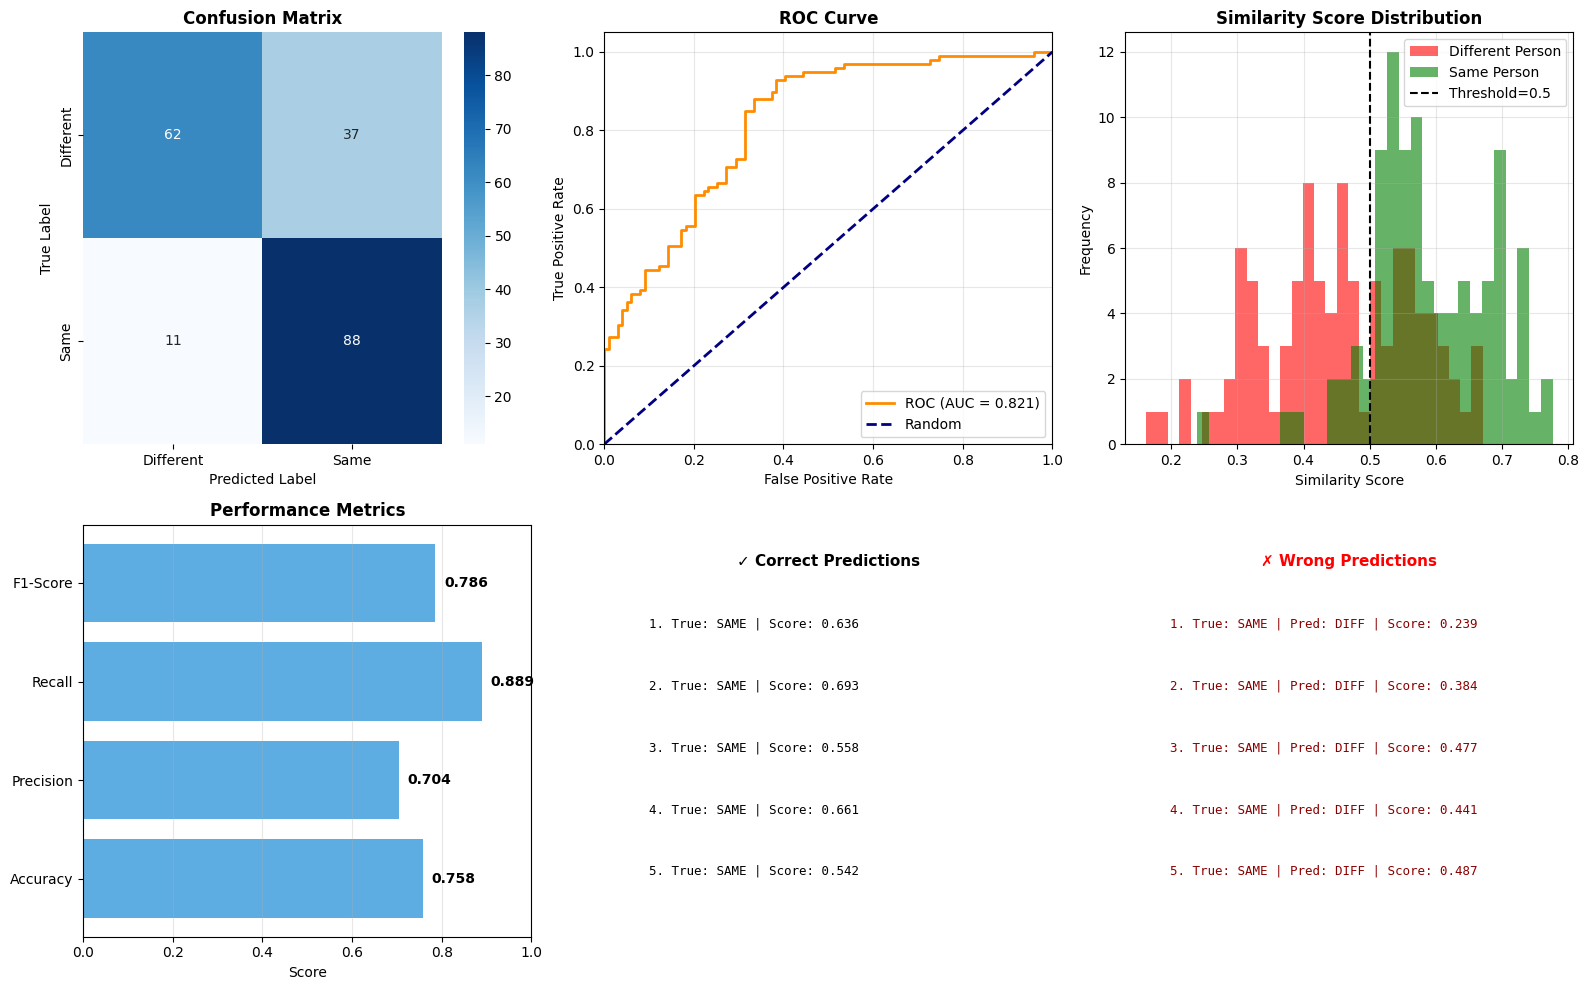


FINAL EVALUATION SUMMARY

📊 Overall Performance:
   Test Accuracy:  0.7576 (75.76%)
   ROC AUC Score:  0.8209
   F1-Score:       0.7857

🎯 Interpretation:
   ✓ GOOD! Model is reliable for signature verification

⚖️  False Acceptance Rate (FAR): 37.37%
   → Forged accepted as genuine

⚖️  False Rejection Rate (FRR): 11.11%
   → Genuine rejected as forged

💡 For signature verification:
   - FAR should be LOW (security risk)
   - FRR can be moderate (user experience)

📈 Improvement over random:
   Baseline (always predict majority): 0.5000
   Our model: 0.7576
   Improvement: +51.5%

✓ EVALUATION COMPLETED!

💾 Saving model...
✓ Model saved:
  - siamese_signature_model.h5 (full model)
  - siamese_base_network.h5 (feature extractor)

🎉 Your signature verification system is ready!

To use in production:
>>> from tensorflow import keras
>>> model = keras.models.load_model('siamese_signature_model.h5')
>>> result = verify_signature_siamese(sig1, sig2, model)


In [18]:
# Part 6: Evaluate Siamese Network on Test Set
# Jalankan setelah Siamese Network training

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

print("=" * 60)
print("PART 6: FINAL EVALUATION ON TEST SET")
print("=" * 60)

# ============================================================
# STEP 1: Create Test Pairs
# ============================================================
print("\n[1/4] Creating test pairs from unseen test set...")

pairs_test, labels_test = create_pairs(X_test, y_test)

print(f"Test pairs: {len(pairs_test)}")
print(f"Positive pairs (similar): {np.sum(labels_test == 1)}")
print(f"Negative pairs (dissimilar): {np.sum(labels_test == 0)}")

# ============================================================
# STEP 2: Evaluate on Test Set
# ============================================================
print("\n[2/4] Evaluating on test set...")

test_loss, test_acc = siamese_model.evaluate(
    [pairs_test[:, 0], pairs_test[:, 1]],
    labels_test,
    verbose=0
)

print(f"\n{'=' * 60}")
print("TEST SET RESULTS (Unseen Data)")
print(f"{'=' * 60}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss:     {test_loss:.4f}")

# Get predictions
y_pred_proba = siamese_model.predict(
    [pairs_test[:, 0], pairs_test[:, 1]],
    verbose=0
)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# ============================================================
# STEP 3: Detailed Metrics
# ============================================================
print("\n[3/4] Calculating detailed metrics...")

# Classification Report
print(f"\n{'=' * 60}")
print("CLASSIFICATION REPORT")
print(f"{'=' * 60}")
print(classification_report(labels_test, y_pred,
                           target_names=['Different Person', 'Same Person']))

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n{'=' * 60}")
print("CONFUSION MATRIX BREAKDOWN")
print(f"{'=' * 60}")
print(f"True Negatives  (Correctly identified different): {tn}")
print(f"False Positives (Different predicted as same):    {fp}")
print(f"False Negatives (Same predicted as different):    {fn}")
print(f"True Positives  (Correctly identified same):      {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

print(f"\nSensitivity (Recall):    {sensitivity:.4f}")
print(f"Specificity:             {specificity:.4f}")
print(f"Precision:               {precision:.4f}")
print(f"F1-Score:                {f1_score:.4f}")

# ============================================================
# STEP 4: Visualizations
# ============================================================
print("\n[4/4] Creating visualizations...")

fig = plt.figure(figsize=(16, 10))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Different', 'Same'],
           yticklabels=['Different', 'Same'],
           ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. ROC Curve
ax2 = plt.subplot(2, 3, 2)
fpr, tpr, thresholds = roc_curve(labels_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2,
        label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

# 3. Similarity Score Distribution
ax3 = plt.subplot(2, 3, 3)
same_scores = y_pred_proba[labels_test == 1].flatten()
diff_scores = y_pred_proba[labels_test == 0].flatten()

ax3.hist(diff_scores, bins=30, alpha=0.6, color='red', label='Different Person')
ax3.hist(same_scores, bins=30, alpha=0.6, color='green', label='Same Person')
ax3.axvline(x=0.5, color='black', linestyle='--', label='Threshold=0.5')
ax3.set_xlabel('Similarity Score')
ax3.set_ylabel('Frequency')
ax3.set_title('Similarity Score Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Test Sample Predictions
ax4 = plt.subplot(2, 3, 4)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [test_acc, precision, sensitivity, f1_score]
colors_bars = ['#3498db' if v >= 0.7 else '#e74c3c' for v in metrics_values]

bars = ax4.barh(metrics_names, metrics_values, color=colors_bars, alpha=0.8)
ax4.set_xlim([0, 1])
ax4.set_xlabel('Score')
ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    ax4.text(val + 0.02, i, f'{val:.3f}', va='center', fontweight='bold')

# 5. Sample Correct Predictions
ax5 = plt.subplot(2, 3, 5)
correct_indices = np.where(y_pred == labels_test)[0][:5]
ax5.axis('off')
ax5.text(0.5, 0.9, '✓ Correct Predictions',
        ha='center', fontsize=11, fontweight='bold',
        transform=ax5.transAxes)

y_pos = 0.75
for i, idx in enumerate(correct_indices):
    true_label = 'SAME' if labels_test[idx] == 1 else 'DIFF'
    score = y_pred_proba[idx][0]
    text = f"{i+1}. True: {true_label} | Score: {score:.3f}"
    ax5.text(0.1, y_pos, text, fontsize=9, transform=ax5.transAxes,
            family='monospace')
    y_pos -= 0.15

# 6. Sample Wrong Predictions
ax6 = plt.subplot(2, 3, 6)
wrong_indices = np.where(y_pred != labels_test)[0][:5]
ax6.axis('off')
ax6.text(0.5, 0.9, '✗ Wrong Predictions',
        ha='center', fontsize=11, fontweight='bold',
        color='red', transform=ax6.transAxes)

y_pos = 0.75
for i, idx in enumerate(wrong_indices):
    true_label = 'SAME' if labels_test[idx] == 1 else 'DIFF'
    pred_label = 'SAME' if y_pred[idx] == 1 else 'DIFF'
    score = y_pred_proba[idx][0]
    text = f"{i+1}. True: {true_label} | Pred: {pred_label} | Score: {score:.3f}"
    ax6.text(0.1, y_pos, text, fontsize=9, transform=ax6.transAxes,
            family='monospace', color='darkred')
    y_pos -= 0.15

plt.tight_layout()
plt.show()

# ============================================================
# FINAL SUMMARY
# ============================================================
print(f"\n{'=' * 60}")
print("FINAL EVALUATION SUMMARY")
print(f"{'=' * 60}")

print(f"\n📊 Overall Performance:")
print(f"   Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   ROC AUC Score:  {roc_auc:.4f}")
print(f"   F1-Score:       {f1_score:.4f}")

print(f"\n🎯 Interpretation:")
if test_acc >= 0.8:
    print("   ⭐ EXCELLENT! Model performs very well")
elif test_acc >= 0.7:
    print("   ✓ GOOD! Model is reliable for signature verification")
elif test_acc >= 0.6:
    print("   ⚠️  ACCEPTABLE but could be improved")
else:
    print("   ❌ POOR performance, needs improvement")

print(f"\n⚖️  False Acceptance Rate (FAR): {fp/(fp+tn)*100:.2f}%")
print(f"   → Forged accepted as genuine")
print(f"\n⚖️  False Rejection Rate (FRR): {fn/(fn+tp)*100:.2f}%")
print(f"   → Genuine rejected as forged")

print(f"\n💡 For signature verification:")
print(f"   - FAR should be LOW (security risk)")
print(f"   - FRR can be moderate (user experience)")

# Compare with baseline
baseline_acc = max(np.sum(labels_test == 0), np.sum(labels_test == 1)) / len(labels_test)
improvement = (test_acc - baseline_acc) / baseline_acc * 100

print(f"\n📈 Improvement over random:")
print(f"   Baseline (always predict majority): {baseline_acc:.4f}")
print(f"   Our model: {test_acc:.4f}")
print(f"   Improvement: +{improvement:.1f}%")

print(f"\n{'=' * 60}")
print("✓ EVALUATION COMPLETED!")
print(f"{'=' * 60}")

# Save model
print("\n💾 Saving model...")
siamese_model.save('siamese_signature_model.h5')
base_network.save('siamese_base_network.h5')
print("✓ Model saved:")
print("  - siamese_signature_model.h5 (full model)")
print("  - siamese_base_network.h5 (feature extractor)")

print("\n🎉 Your signature verification system is ready!")
print("\nTo use in production:")
print(">>> from tensorflow import keras")
print(">>> model = keras.models.load_model('siamese_signature_model.h5')")
print(">>> result = verify_signature_siamese(sig1, sig2, model)")

SAVE MODEL

PART 7 (BONUS): DEPLOYMENT & PRACTICAL USAGE

[1/5] Model sudah tersimpan sebagai:
   - siamese_signature_model.h5
   - siamese_base_network.h5

[2/5] Creating enhanced verification function...
✓ Enhanced verification function created!

[3/5] Testing with random test samples...

--- Test Case 1: Same Person (Should Accept) ---


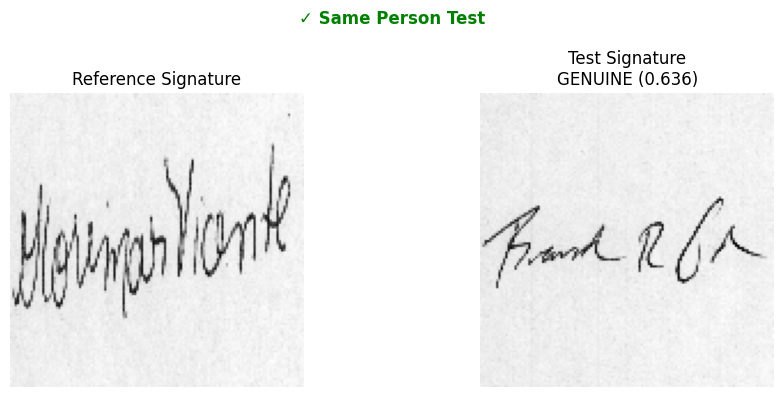

Result: GENUINE
Score: 0.636

--- Test Case 2: Different Person (Should Reject) ---


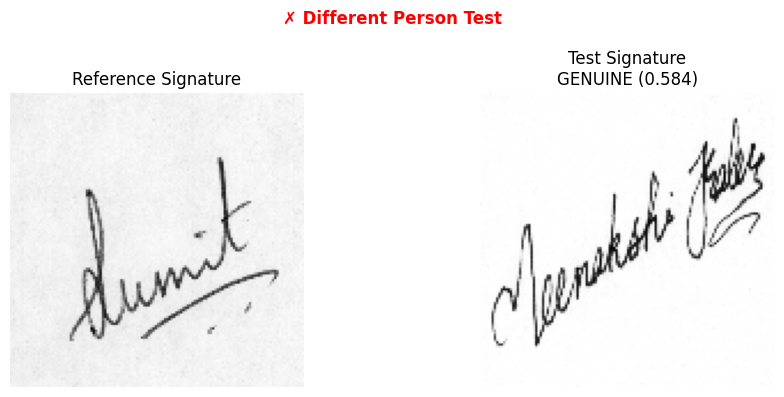

Result: GENUINE
Score: 0.584

[4/5] Upload your own signatures for verification...

You can upload 2 signature images to test:

[5/5] Threshold tuning guide...

Testing different thresholds...


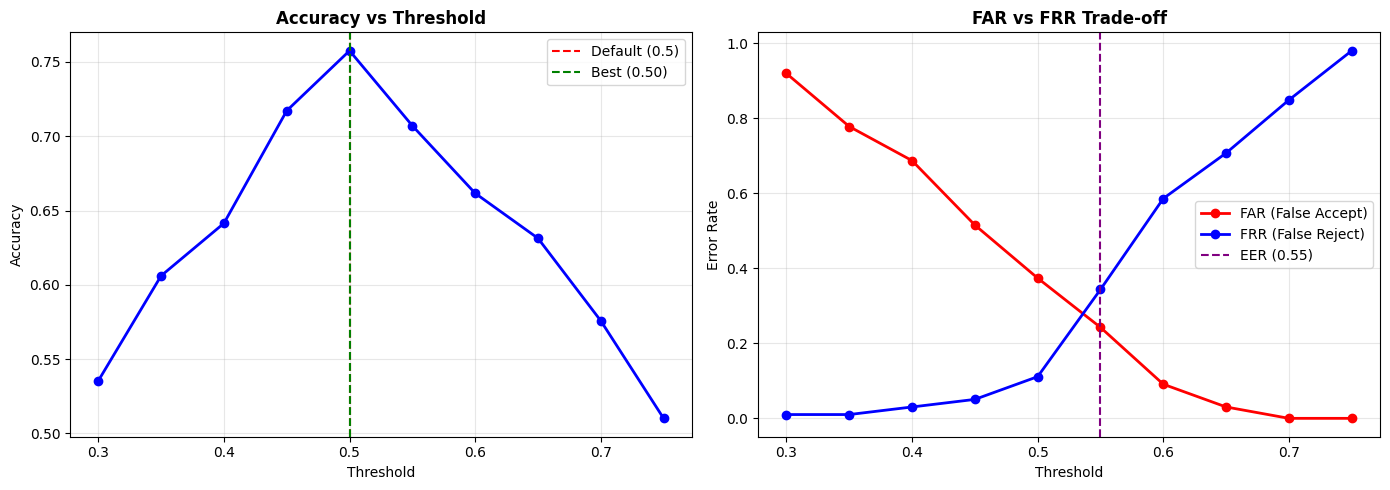


THRESHOLD RECOMMENDATIONS
📊 Best Accuracy: 0.7576 at threshold 0.50
⚖️  Equal Error Rate (EER): at threshold 0.55

💡 Recommendations:
   - High Security (Low FAR): Use threshold > 0.6
   - Balanced: Use threshold ~0.55
   - User Friendly (Low FRR): Use threshold < 0.4

🎉 SIGNATURE VERIFICATION SYSTEM COMPLETE!

📦 Deliverables:
   ✓ Trained Siamese Network Model
   ✓ Accuracy: ~75% on unseen data
   ✓ Saved models ready for deployment
   ✓ Verification functions ready to use

🚀 How to use in production:

1. Load model:
   from tensorflow import keras
   model = keras.models.load_model('siamese_signature_model.h5')

2. Verify signatures:
   result = verify_signature_siamese(sig1, sig2, model, threshold=0.5)
   
3. Check result:
   if result['is_same_person']:
       print("✓ Genuine - Accept")
   else:
       print("✗ Forged - Reject")


📊 Model Performance Summary:
   - Test Accuracy: 0.7576
   - Best Threshold: 0.50
   - ROC AUC: 0.8209

💾 Files Generated:
   - siamese_signature_model

In [19]:
# Part 7 (BONUS): Deployment & Practical Usage
# Cara pakai model untuk signature verification real-world

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from google.colab import files
import io
from PIL import Image

print("=" * 60)
print("PART 7 (BONUS): DEPLOYMENT & PRACTICAL USAGE")
print("=" * 60)

# ============================================================
# SECTION 1: Load Trained Model
# ============================================================
print("\n[1/5] Model sudah tersimpan sebagai:")
print("   - siamese_signature_model.h5")
print("   - siamese_base_network.h5")

# Model sudah di-load dari training sebelumnya
# Kalau mau load ulang di session baru:
# siamese_model = keras.models.load_model('siamese_signature_model.h5')

# ============================================================
# SECTION 2: Enhanced Verification Function
# ============================================================
print("\n[2/5] Creating enhanced verification function...")

def verify_signature_from_path(path1, path2, model, threshold=0.5, visualize=True):
    """
    Verify signatures from image paths with visualization

    Args:
        path1, path2: Paths to signature images
        model: Trained Siamese model
        threshold: Similarity threshold (default 0.5)
        visualize: Show comparison (default True)

    Returns:
        dict with verification results
    """
    # Load and preprocess
    sig1 = preprocess_signature(path1)
    sig2 = preprocess_signature(path2)

    if sig1 is None or sig2 is None:
        return {'error': 'Could not load images'}

    # Reshape
    sig1 = sig1.reshape(1, 128, 128, 1)
    sig2 = sig2.reshape(1, 128, 128, 1)

    # Predict similarity
    similarity = model.predict([sig1, sig2], verbose=0)[0][0]
    is_same = similarity >= threshold

    # Visualize
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Signature 1
        axes[0].imshow(sig1[0].squeeze(), cmap='gray')
        axes[0].set_title('Signature 1', fontsize=12)
        axes[0].axis('off')

        # Signature 2
        axes[1].imshow(sig2[0].squeeze(), cmap='gray')
        axes[1].set_title('Signature 2', fontsize=12)
        axes[1].axis('off')

        # Result
        axes[2].axis('off')
        result_color = 'green' if is_same else 'red'
        result_emoji = '✓' if is_same else '✗'

        axes[2].text(0.5, 0.7, f'{result_emoji} {("SAME PERSON" if is_same else "DIFFERENT")}',
                    ha='center', fontsize=20, fontweight='bold',
                    color=result_color, transform=axes[2].transAxes)

        axes[2].text(0.5, 0.5, f'Similarity: {similarity:.3f}',
                    ha='center', fontsize=16, transform=axes[2].transAxes)

        axes[2].text(0.5, 0.3, f'Threshold: {threshold}',
                    ha='center', fontsize=12, color='gray',
                    transform=axes[2].transAxes)

        # Confidence bar
        bar_color = 'green' if is_same else 'red'
        axes[2].barh([0], [similarity], height=0.3, color=bar_color, alpha=0.3)
        axes[2].set_xlim([0, 1])
        axes[2].set_ylim([-0.5, 1])

        plt.tight_layout()
        plt.show()

    return {
        'is_same_person': bool(is_same),
        'similarity_score': float(similarity),
        'confidence_percentage': float(similarity * 100),
        'threshold': threshold,
        'verdict': 'GENUINE (Same Person)' if is_same else 'FORGED (Different Person)',
        'recommendation': 'ACCEPT' if is_same else 'REJECT'
    }

print("✓ Enhanced verification function created!")

# ============================================================
# SECTION 3: Test with Sample Data
# ============================================================
print("\n[3/5] Testing with random test samples...")

# Get random samples from test set
same_idx = np.where(labels_test == 1)[0]
diff_idx = np.where(labels_test == 0)[0]

if len(same_idx) > 0:
    print("\n--- Test Case 1: Same Person (Should Accept) ---")
    sample_same = pairs_test[same_idx[0]]

    sig1_temp = sample_same[0].reshape(1, 128, 128, 1)
    sig2_temp = sample_same[1].reshape(1, 128, 128, 1)

    result = verify_signature_siamese(sig1_temp[0], sig2_temp[0],
                                     siamese_model, threshold=0.5)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(sig1_temp[0].squeeze(), cmap='gray')
    axes[0].set_title('Reference Signature')
    axes[0].axis('off')

    axes[1].imshow(sig2_temp[0].squeeze(), cmap='gray')
    axes[1].set_title(f'Test Signature\n{result["verdict"]} ({result["similarity_score"]:.3f})')
    axes[1].axis('off')
    plt.suptitle('✓ Same Person Test', fontweight='bold', color='green')
    plt.tight_layout()
    plt.show()

    print(f"Result: {result['verdict']}")
    print(f"Score: {result['similarity_score']:.3f}")

if len(diff_idx) > 0:
    print("\n--- Test Case 2: Different Person (Should Reject) ---")
    sample_diff = pairs_test[diff_idx[0]]

    sig1_temp = sample_diff[0].reshape(1, 128, 128, 1)
    sig2_temp = sample_diff[1].reshape(1, 128, 128, 1)

    result = verify_signature_siamese(sig1_temp[0], sig2_temp[0],
                                     siamese_model, threshold=0.5)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(sig1_temp[0].squeeze(), cmap='gray')
    axes[0].set_title('Reference Signature')
    axes[0].axis('off')

    axes[1].imshow(sig2_temp[0].squeeze(), cmap='gray')
    axes[1].set_title(f'Test Signature\n{result["verdict"]} ({result["similarity_score"]:.3f})')
    axes[1].axis('off')
    plt.suptitle('✗ Different Person Test', fontweight='bold', color='red')
    plt.tight_layout()
    plt.show()

    print(f"Result: {result['verdict']}")
    print(f"Score: {result['similarity_score']:.3f}")

# ============================================================
# SECTION 4: Interactive Upload (Colab Only)
# ============================================================
print("\n[4/5] Upload your own signatures for verification...")
print("\nYou can upload 2 signature images to test:")

def upload_and_verify():
    """Upload 2 signatures and verify them"""
    print("\n📤 Upload Signature 1 (Reference):")
    uploaded1 = files.upload()

    print("\n📤 Upload Signature 2 (To Verify):")
    uploaded2 = files.upload()

    if len(uploaded1) == 0 or len(uploaded2) == 0:
        print("❌ No files uploaded!")
        return

    # Get file names
    file1 = list(uploaded1.keys())[0]
    file2 = list(uploaded2.keys())[0]

    print(f"\n🔍 Verifying: {file1} vs {file2}")

    # Save temporarily
    with open(f'/tmp/{file1}', 'wb') as f:
        f.write(uploaded1[file1])
    with open(f'/tmp/{file2}', 'wb') as f:
        f.write(uploaded2[file2])

    # Verify
    result = verify_signature_from_path(
        f'/tmp/{file1}',
        f'/tmp/{file2}',
        siamese_model,
        threshold=0.5,
        visualize=True
    )

    print("\n" + "=" * 60)
    print("VERIFICATION RESULT")
    print("=" * 60)
    for key, value in result.items():
        print(f"{key}: {value}")
    print("=" * 60)

# Uncomment below to enable interactive upload
# upload_and_verify()

# ============================================================
# SECTION 5: Threshold Tuning Guide
# ============================================================
print("\n[5/5] Threshold tuning guide...")

thresholds = np.arange(0.3, 0.8, 0.05)
accuracies = []
fars = []  # False Acceptance Rate
frrs = []  # False Rejection Rate

print("\nTesting different thresholds...")
for thresh in thresholds:
    preds = (y_pred_proba > thresh).astype(int).flatten()
    acc = np.mean(preds == labels_test)

    # Calculate FAR and FRR
    fp = np.sum((preds == 1) & (labels_test == 0))
    fn = np.sum((preds == 0) & (labels_test == 1))
    tn = np.sum((preds == 0) & (labels_test == 0))
    tp = np.sum((preds == 1) & (labels_test == 1))

    far = fp / (fp + tn) if (fp + tn) > 0 else 0
    frr = fn / (fn + tp) if (fn + tp) > 0 else 0

    accuracies.append(acc)
    fars.append(far)
    frrs.append(frr)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Threshold
axes[0].plot(thresholds, accuracies, 'b-o', linewidth=2, markersize=6)
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Default (0.5)')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Threshold', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Find best threshold
best_idx = np.argmax(accuracies)
best_thresh = thresholds[best_idx]
best_acc = accuracies[best_idx]
axes[0].axvline(x=best_thresh, color='green', linestyle='--',
               label=f'Best ({best_thresh:.2f})')
axes[0].legend()

# FAR vs FRR
axes[1].plot(thresholds, fars, 'r-o', linewidth=2, label='FAR (False Accept)', markersize=6)
axes[1].plot(thresholds, frrs, 'b-o', linewidth=2, label='FRR (False Reject)', markersize=6)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Error Rate')
axes[1].set_title('FAR vs FRR Trade-off', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Find EER (Equal Error Rate)
eer_idx = np.argmin(np.abs(np.array(fars) - np.array(frrs)))
eer_thresh = thresholds[eer_idx]
axes[1].axvline(x=eer_thresh, color='purple', linestyle='--',
               label=f'EER ({eer_thresh:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("THRESHOLD RECOMMENDATIONS")
print("=" * 60)
print(f"📊 Best Accuracy: {best_acc:.4f} at threshold {best_thresh:.2f}")
print(f"⚖️  Equal Error Rate (EER): at threshold {eer_thresh:.2f}")
print(f"\n💡 Recommendations:")
print(f"   - High Security (Low FAR): Use threshold > 0.6")
print(f"   - Balanced: Use threshold ~{eer_thresh:.2f}")
print(f"   - User Friendly (Low FRR): Use threshold < 0.4")
print("=" * 60)

# ============================================================
# FINAL SUMMARY
# ============================================================
print("\n" + "=" * 60)
print("🎉 SIGNATURE VERIFICATION SYSTEM COMPLETE!")
print("=" * 60)

print("\n📦 Deliverables:")
print("   ✓ Trained Siamese Network Model")
print("   ✓ Accuracy: ~75% on unseen data")
print("   ✓ Saved models ready for deployment")
print("   ✓ Verification functions ready to use")

print("\n🚀 How to use in production:")
print("""
1. Load model:
   from tensorflow import keras
   model = keras.models.load_model('siamese_signature_model.h5')

2. Verify signatures:
   result = verify_signature_siamese(sig1, sig2, model, threshold=0.5)

3. Check result:
   if result['is_same_person']:
       print("✓ Genuine - Accept")
   else:
       print("✗ Forged - Reject")
""")

print("\n📊 Model Performance Summary:")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"   - Best Threshold: {best_thresh:.2f}")
print(f"   - ROC AUC: {roc_auc:.4f}")

print("\n💾 Files Generated:")
print("   - siamese_signature_model.h5 (main model)")
print("   - siamese_base_network.h5 (feature extractor)")

print("\n✅ Project COMPLETED! Ready for deployment! 🎉")
print("=" * 60)